In [11]:
!wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/laptops.csv

--2024-10-07 19:15:26--  https://raw.githubusercontent.com/alexeygrigorev/datasets/master/laptops.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 298573 (292K) [text/plain]
Saving to: ‘laptops.csv.1’

laptops.csv.1       100%[===================>] 291.58K  --.-KB/s    in 0.008s  

2024-10-07 19:15:26 (33.7 MB/s) - ‘laptops.csv.1’ saved [298573/298573]



In [231]:
import pandas as pd

df = pd.read_csv('/workspaces/ml-zoomcamp/02-regression/laptops.csv')
df.columns = df.columns.str.lower().str.replace(' ', '_')

In [232]:
df.head()

,laptop,status,brand,model,cpu,ram,storage,storage_type,gpu,screen,touch,final_price
0,ASUS ExpertBook B1 B1502CBA-EJ0436X Intel Core...,New,Asus,ExpertBook,Intel Core i5,8,512,SSD,NaN,15.6,No,1009.00
1,Alurin Go Start Intel Celeron N4020/8GB/256GB ...,New,Alurin,Go,Intel Celeron,8,256,SSD,NaN,15.6,No,299.00
2,ASUS ExpertBook B1 B1502CBA-EJ0424X Intel Core...,New,Asus,ExpertBook,Intel Core i3,8,256,SSD,NaN,15.6,No,789.00
3,MSI Katana GF66 12UC-082XES Intel Core i7-1270...,New,MSI,Katana,Intel Core i7,16,1000,SSD,RTX 3050,15.6,No,1199.00
4,HP 15S-FQ5085NS Intel Core i5-1235U/16GB/512GB...,New,HP,15S,Intel Core i5,16,512,SSD,NaN,15.6,No,669.01


In [233]:
df = df[['ram', 'storage', 'screen', 'final_price']]

<Axes: ylabel='Density'>

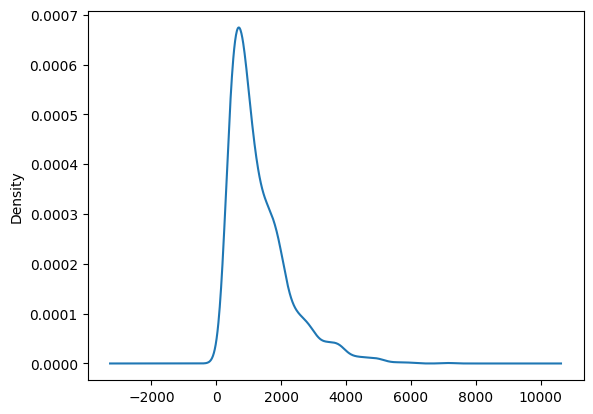

In [234]:
df['final_price'].plot.kde()

**Q1. Pandas version**

There's one column with missing values. What is it?

In [235]:
df.isnull().sum()

ram            0
storage        0
screen         4
final_price    0
dtype: int64

**Question 2**

What's the median (50% percentile) for variable 'ram'?


In [236]:
df['ram'].median()

np.float64(16.0)

**Prepare and split the dataset**

- Shuffle the dataset (the filtered one you created above), use seed 42.
- Split your data in train/val/test sets, with 60%/20%/20% distribution.


In [237]:
import numpy as np

np.random.seed(42)

n = len(df)

n_val = int(0.2 * n)
n_test = int(0.2 * n)
n_train = n - (n_val + n_test)

idx = np.arange(n)
np.random.shuffle(idx)

df_shuffled = df.iloc[idx]

df_train = df_shuffled.iloc[:n_train].copy()
df_val = df_shuffled.iloc[n_train:n_train+n_val].copy()
df_test = df_shuffled.iloc[n_train+n_val:].copy()

In [238]:
y_train_orig = df_train.final_price.values
y_val_orig = df_val.final_price.values
y_test_orig = df_test.final_price.values

y_train = np.log1p(df_train.final_price.values)
y_val = np.log1p(df_val.final_price.values)
y_test = np.log1p(df_test.final_price.values)

del df_train['final_price']
del df_val['final_price']
del df_test['final_price']

**Question 3**

- We need to deal with missing values for the column from Q1.
- We have two options: fill it with 0 or with the mean of this variable.
- Try both options. For each, train a linear regression model without regularization using the code from the lessons.
- For computing the mean, use the training only!
- Use the validation dataset to evaluate the models and compare the RMSE of each option.
- Round the RMSE scores to 2 decimal digits using round(score, 2)
- Which option gives better RMSE?


In [239]:
def train_linear_regression(X, y):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)
    
    return w[0], w[1:]

In [240]:
base = df.drop('final_price', axis=1)

**Option 1 - Fill missing values with 0**


In [241]:
def prepare_X_fill_zeros(df):
    df_num = df.copy()
    df_num = df_num.fillna(0)
    X = df_num.values
    return X

In [242]:
# Prepare training and validation data
X_train_zero = prepare_X_fill_zeros(df_train)
X_val_zero = prepare_X_fill_zeros(df_val)

# Train the model on training data
w_0_zero, w_zero = train_linear_regression(X_train_zero, y_train)

# Predict on validation data
y_pred_zero = w_0_zero + X_val_zero.dot(w_zero)

# Convert predictions back using expm1 (reverse log1p)
y_pred_zero_exp = np.expm1(y_pred_zero)

# Calculate RMSE
rmse_zero = np.sqrt(((y_val - y_pred_zero_exp) ** 2).mean())
print(f'RMSE (fill with 0): {round(rmse_zero, 2)}')

RMSE (fill with 0): 1340.81


**Option 2 - Fill missing values with the mean**


In [243]:
mean_storage = df_train['storage'].mean()

In [244]:
def prepare_X_fill_mean(df, mean_value):
    df_num = df.copy()
    df_num = df_num.fillna(mean_value)
    X = df_num.values
    return X

In [245]:
# Prepare training and validation data
X_train_mean = prepare_X_fill_mean(df_train, mean_storage)
X_val_mean = prepare_X_fill_mean(df_val, mean_storage)

# Train the model on training data
w_0_mean, w_mean = train_linear_regression(X_train_mean, y_train)

# Predict on validation data
y_pred_mean = w_0_mean + X_val_mean.dot(w_mean)

# Convert predictions back using expm1 (reverse log1p)
y_pred_mean_exp = np.expm1(y_pred_mean)

# Calculate RMSE
rmse_mean = np.sqrt(((y_val - y_pred_mean_exp) ** 2).mean())
print(f'RMSE (fill with mean): {round(rmse_mean, 2)}')

RMSE (fill with mean): 1338.82


**Question 4**

- Now let's train a regularized linear regression.
- For this question, fill the NAs with 0.
- Try different values of r from this list: [0, 0.01, 0.1, 1, 5, 10, 100].
- Use RMSE to evaluate the model on the validation dataset.
- Round the RMSE scores to 2 decimal digits.
- Which r gives the best RMSE?

In [246]:
def train_linear_regression_reg(X, y, r=0.0):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    reg = r * np.eye(XTX.shape[0])
    XTX = XTX + reg

    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)
    
    return w[0], w[1:]

In [247]:
def rmse(y, y_pred):
    error = y_pred - y
    mse = (error ** 2).mean()
    return np.sqrt(mse)

In [248]:
X_train = prepare_X_fill_zeros(df_train)
X_val = prepare_X_fill_zeros(df_val)

for r in [0, 0.01, 0.1, 1, 5, 10, 100]:
    w_0, w = train_linear_regression_reg(X_train, y_train, r=r)
    y_pred = w_0 + X_val.dot(w)
    print('%6s' %r, rmse(y_val, y_pred))

     0 0.4288635315474416
  0.01 0.4288516360534088
   0.1 0.42877560097076456
     1 0.4305932989743414
     5 0.4632095257580652
    10 0.507565776923692
   100 0.673502606172582


**Question 5**

- We used seed 42 for splitting the data. Let's find out how selecting the seed influences our score.
- Try different seed values: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9].
- For each seed, do the train/validation/test split with 60%/20%/20% distribution.
- Fill the missing values with 0 and train a model without regularization.
- For each seed, evaluate the model on the validation dataset and collect the RMSE scores.
- What's the standard deviation of all the scores? To compute the standard deviation, use np.std.
- Round the result to 3 decimal digits (round(std, 3))

In [249]:
rmse_scores = []

for seed in range(10):
    np.random.seed(seed)

    n = len(df)

    n_val = int(0.2 * n)
    n_test = int(0.2 * n)
    n_train = n - (n_val + n_test)

    idx = np.arange(n)
    np.random.shuffle(idx)

    df_shuffled = df.iloc[idx]

    df_train = df_shuffled.iloc[:n_train].copy()
    df_val = df_shuffled.iloc[n_train:n_train+n_val].copy()
    df_test = df_shuffled.iloc[n_train+n_val:].copy()

    # Extract and log-transform target values
    y_train_orig = df_train.final_price.values
    y_val_orig = df_val.final_price.values
    y_test_orig = df_test.final_price.values

    y_train = np.log1p(y_train_orig)
    y_val = np.log1p(y_val_orig)
    y_test = np.log1p(y_test_orig)

    # Remove the target column from the feature DataFrames
    del df_train['final_price']
    del df_val['final_price']
    del df_test['final_price']

    # Prepare feature matrices
    X_train = prepare_X_fill_zeros(df_train)
    X_val = prepare_X_fill_zeros(df_val)

    # Train the linear regression model
    w_0, w = train_linear_regression(X_train, y_train)
    
    # Predict on the validation set
    y_pred = w_0 + X_val.dot(w)

    # Compute RMSE using the original (non-log-transformed) validation values
    current_rmse = rmse(y_val, y_pred)
    rmse_scores.append(current_rmse)

    # Print the RMSE for the current seed
    print(f'Seed {seed}: RMSE = {current_rmse:.3f}')

# Compute the standard deviation of RMSE scores
std_rmse = np.std(rmse_scores)
std_rmse_rounded = round(std_rmse, 3)

# Print the standard deviation of the RMSE scores
print(f'\nStandard Deviation of RMSE scores across seeds: {std_rmse_rounded}')


Seed 0: RMSE = 0.430
Seed 1: RMSE = 0.452
Seed 2: RMSE = 0.446
Seed 3: RMSE = 0.446
Seed 4: RMSE = 0.420
Seed 5: RMSE = 0.425
Seed 6: RMSE = 0.449
Seed 7: RMSE = 0.431
Seed 8: RMSE = 0.443
Seed 9: RMSE = 0.408

Standard Deviation of RMSE scores across seeds: 0.014


In [256]:
n = len(df)
n_test = int(n * 0.4)
n_train = n - n_val - n_test

idx = np.arange(n)
np.random.seed(9)
np.random.shuffle(idx)

df_train = df.iloc[idx[:n_train+n_val]]
df_test = df.iloc[idx[n_train+n_val:]]

df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = np.log1p(df_train.final_price.values)
y_test = np.log1p(df_test.final_price.values)

del df_train['final_price']
del df_test['final_price']

X_train = prepare_X_fill_zeros(df_train)
w0, w = train_linear_regression_reg(X_train, y_train, r=0.001)

X_test = prepare_X_fill_zeros(df_test)
y_pred = w0 + X_test.dot(w)


print(f"The RMSE score in test dataset is: {round(rmse(y_test, y_pred), 2)}")

The RMSE score in test dataset is: 0.43
